# find in P3 that further cycling the cell will cause porosity goes to zero, even with unlimited reservior
# therefore, now i want to see, what happen if I turn on dryout model but with limited reservior, will there still be porosity decreasing to zero?
# three cases:
# 1. unlimited reservoir, dry-out on --> pore closure
# 2. limited reservoir, dry-out on --> interesting to see.
# 3. dry-out off --> pore closure 

In [36]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
import scipy.optimize
import random;import time, signal
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [37]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P2"))
sys.path.append(str_path_1) 
from Fun_P2 import *

In [38]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[8,], # 1170
   "Ageing cycles between RPT":[4,],
   "Update cycles for ageing":[4,],
   "Cycles within RPT":[1,],
   "Ageing temperature":[25,],
   "RPT temperature":[25,],
   "Particle mesh points":[30,],   # Simon uses 30
   #"Exponential mesh stretch":[1.0],
   "Para_Set":[ "Li2023_Coupled",],
   "Model option":[
         {
            "calculate discharge energy":"true",
            "SEI":"interstitial-diffusion limited",             
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",    },
         ],
   "Inner SEI reaction proportion":[0.5,],
   "Ratio of lithium moles to SEI moles":[2,], # I have always been using 1 for solvent consumption model
   "Initial inner SEI thickness [m]":[2.5E-9,],
   "Initial outer SEI thickness [m]":[2.5E-9,],
   "SEI growth activation energy [J.mol-1]":[38000,],
   # Solvent consumption sub-model
   "Initial electrolyte excessive amount ratio":[1.2, 2,], # set to <1 for DryOut=Off 
   "Current solvent concentration in the reservoir [mol.m-3]":[4541.0,],
   "Current electrolyte concentration in the reservoir [mol.m-3]":[1000,],
   "Ratio of Li-ion concentration change in electrolyte consider solvent consumption":[1.0,],
   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],

   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[3e-20,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity [m2.s-1]':[1e-22,],
   'SEI kinetic rate constant [m.s-1]':[1e-12,], 
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
   'Typical EC concentration in electrolyte [mol.m-3]':[4541.0,], # Mark Ruihe change, act as an initial value here
   # LiP and coupling with SEI:
   "Dead lithium decay constant [s-1]":[ 1e-7,],            # default: 1e-6
   'Lithium plating kinetic rate constant [m.s-1]':[3E-10,], # default: 1e-9
   # Crack model
   "Negative electrode LAM constant proportional term [s-1]":[ 2.7778e-9,], # default: 2.7778e-07
   "Positive electrode LAM constant proportional term [s-1]":[ 2.7778e-9,], # default: 2.7778e-07
   # make it simple for now,], but may want to have T dependency in the future
   "Negative electrode cracking rate":[ 3.9e-22,],   # default: function, ~3.9e-20
   "Positive electrode cracking rate":[ 3.9e-22,],   # default: function, ~3.9e-20
   "Negative electrode volume change":[ 0.0,],
   "Positive electrode volume change":[ 0.0,],
   #"Initial Neg SOC":[0.850],    #list(np.linspace(0.84,0.90,6)),
   #"Initial Pos SOC":[0.2705], # list(np.linspace(0.22,0.27,6)),

}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 2


In [39]:
# define experiments and output keys
V_max = 4.2;        
V_min = 2.5; 
exp_AGE_text = [(f"Discharge at 1 C until {V_min} V", 
        f"Charge at 0.3 C until {V_max} V", 
        f"Hold at {V_max} V until C/100"),  ]
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ (f"Discharge at 0.1C until {V_min} V",  
        "Rest for 1 hours",  
        f"Charge at 0.1C until {V_max} V" ) ]
# step index for RPT
step_RPT_CD = 0;  step_RPT_RE =1;   step_RPT_CC = 2;  

exp_text_list = [exp_AGE_text, exp_RPT_text,];
cycle_no = -1; 
exp_index_pack = [cycle_no,step_AGE_CD,step_AGE_CC,step_AGE_CV,
   step_RPT_CD,step_RPT_RE , step_RPT_CC ];

#len(Para_dict_list)

########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",


    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",


]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "RE Terminal voltage [V]",
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    #"CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",

    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
    "CDend Throughput capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [];
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [40]:
# Main code to run the model
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P2R7'; 
#BasicPath=os.getcwd()
Target  = '/a0Int_HowCellDie/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'a0Int_HowCellDie.xlsx';

sheet_name_xlsx = 'Results';

Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];

# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.insert(1,"Dry out");
head_list.extend([ "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"])
Values_1 = [head_list,];
index_list = np.arange(1,len(Para_dict_list)+1,1).tolist()  
for Scan_i,Para_dict_i in zip(index_list,Para_dict_list):
    value_list_temp = list(Para_dict_i.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(Scan_i))
    Values_1.append(values)
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, Values_1)   

Niall_data = loadmat( str_path_1+'\Extracted_all_cell.mat')


Successfully create a excel file


Start Now! Scan 1.
Scan 1: DryOut = On
Initial electrolyte amount is  6.44126184 mL
Scan 1: Finish break-in cycle
Temperature for ageing is now: 298.15
Temperature for RPT is now: 298.15


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2023-01-08 00:18:34.684 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=0.0 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=113.46612775644178) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.


Scan 1: Fail during No.4 ageing cycles due to Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 704, in _run_integrator
    casadi_sol = integrator(
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 13453, in __call__
    return self.call(kwargs)
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 12324, in call
    return _casadi.Function_call(self, *args)
RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 240, in _integrate
    current_step_sol = self._run_integrator(
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_so

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2023-01-08 00:18:37.394 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=0.0 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=113.46612775644178) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.


Scan 1: Fail during No.4 RPT cycles, due to Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 704, in _run_integrator
    casadi_sol = integrator(
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 13453, in __call__
    return self.call(kwargs)
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 12324, in call
    return _casadi.Function_call(self, *args)
RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 240, in _integrate
    current_step_sol = self._run_integrator(
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solv

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Temperature for ageing is now: 298.15
Temperature for RPT is now: 298.15


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2023-01-08 00:25:21.859 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=0.0 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=113.46612775644178) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.


Scan 2: Fail during No.4 ageing cycles due to Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 704, in _run_integrator
    casadi_sol = integrator(
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 13453, in __call__
    return self.call(kwargs)
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 12324, in call
    return _casadi.Function_call(self, *args)
RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 240, in _integrate
    current_step_sol = self._run_integrator(
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_so

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2023-01-08 00:25:24.303 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=0.0 (final SolverError: '.../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.'). For a full solution try reducing dt_max (currently, dt_max=113.46612775644178) and/or reducing the size of the time steps or period of the experiment. Set `return_solution_if_failed_early=True` to return the solution object up to the point where failure occured.


Scan 2: Fail during No.4 RPT cycles, due to Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 704, in _run_integrator
    casadi_sol = integrator(
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 13453, in __call__
    return self.call(kwargs)
  File "d:\GitPyBaMM\LRH_409\LRH_409\envPBGEM\lib\site-packages\casadi\casadi.py", line 12324, in call
    return _casadi.Function_call(self, *args)
RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solver.py", line 240, in _integrate
    current_step_sol = self._run_integrator(
  File "d:\gitpybamm\lrh_409\lrh_409\envpbgem\pybamm-gem\pybamm\solvers\casadi_solv

' \nif __name__ == "__main__":\n    pool = multiprocessing.Pool(1)\n    processes = [pool.apply_async(\n        Run_model_wwo_dry_out, \n        args=(\n            index_list_i, Para_dict_i,   Path_pack,\n            keys_all,   exp_text_list, exp_index_pack,Niall_data\n        )\n            ) \n            for index_list_i, Para_dict_i in zip(index_list,Para_dict_list)]\n    result = [p.get() for p in processes]\n '

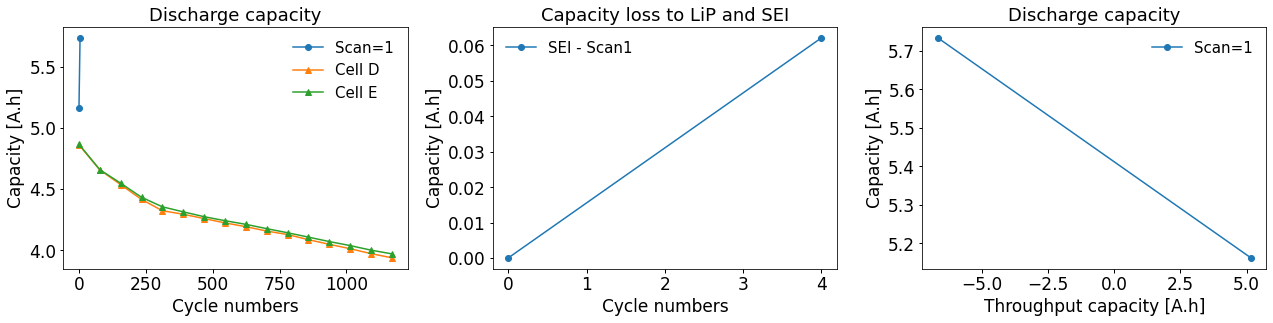

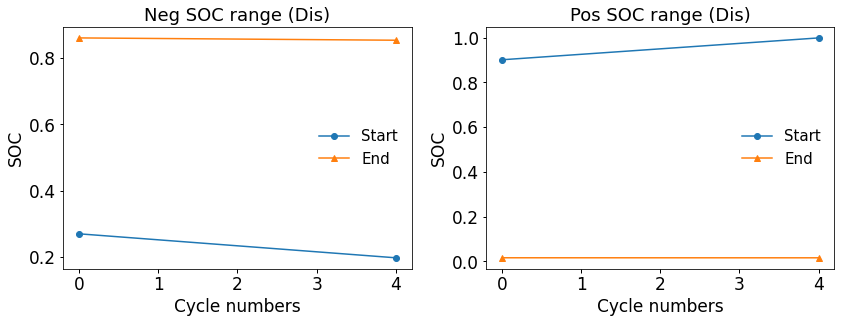

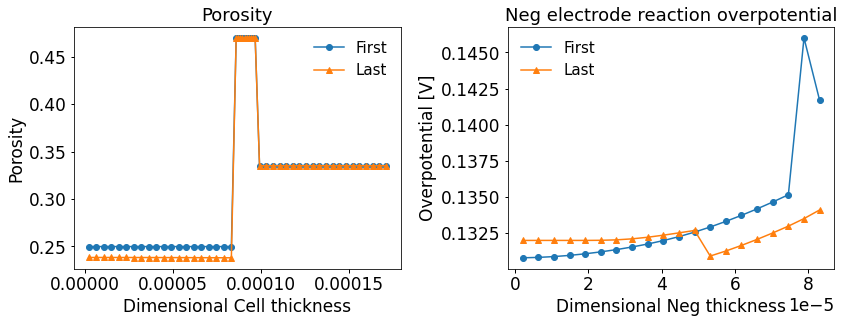

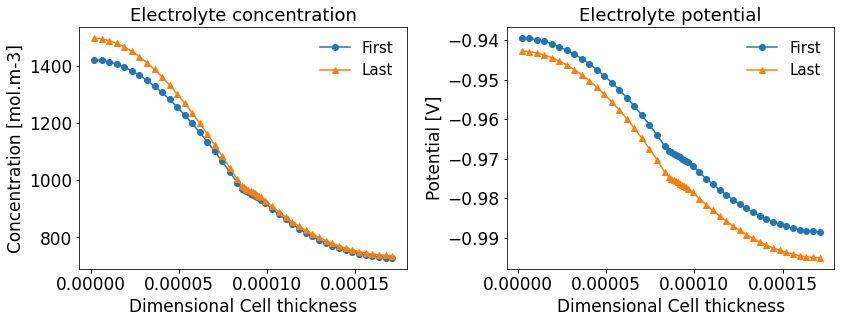

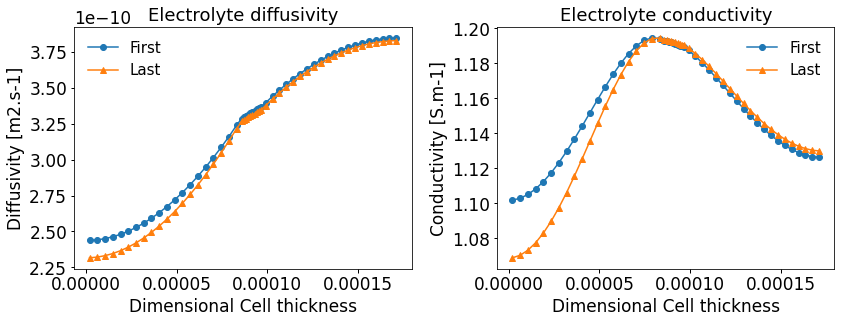

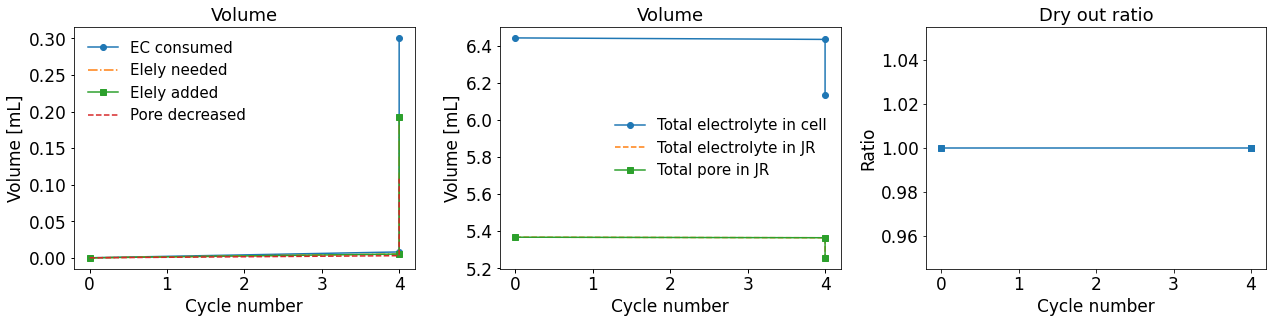

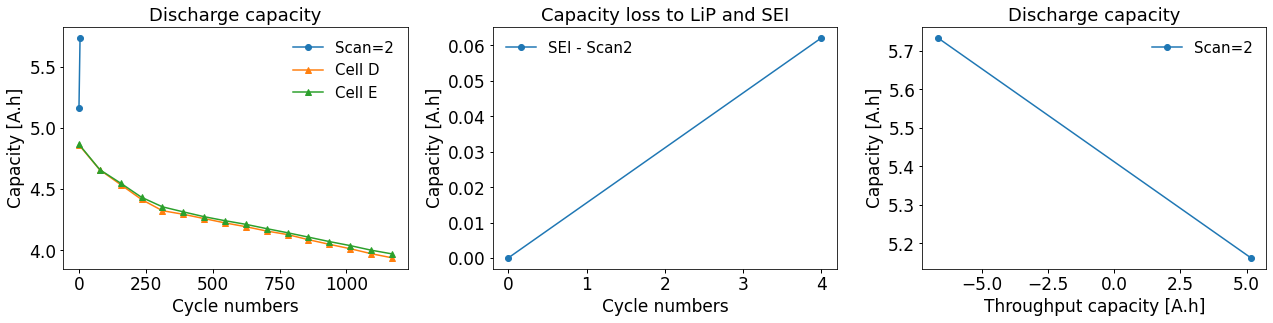

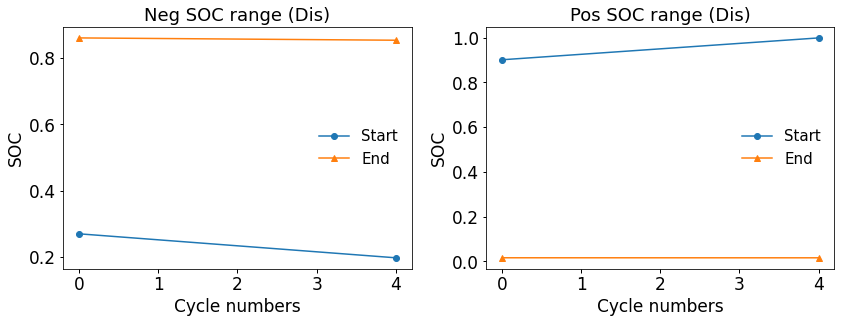

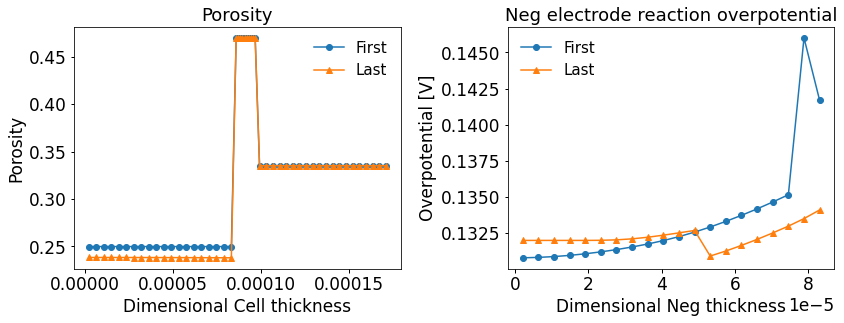

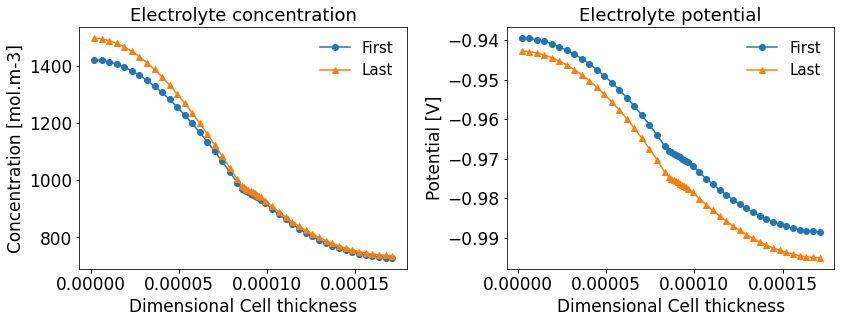

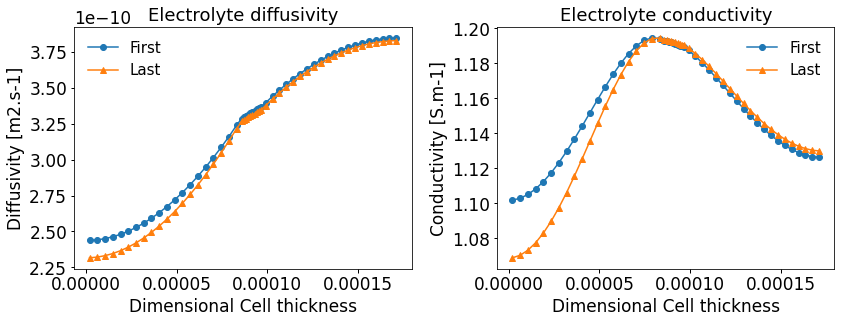

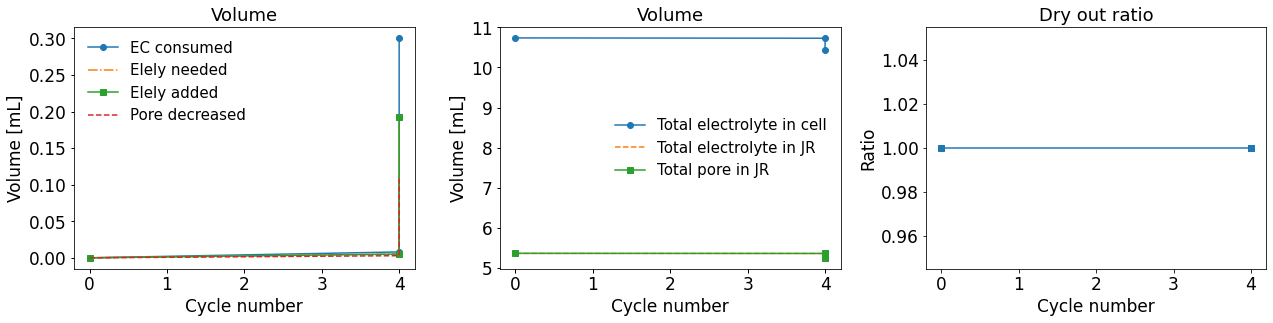

In [41]:
# scan:
index_list = np.arange(1,len(Para_dict_list)+1,1)
for index_list_i, Para_dict_i in zip(index_list,Para_dict_list):
    Run_P2_till_Fail(
        index_list_i, Para_dict_i,   Path_pack,
        keys_all,   exp_text_list, exp_index_pack,Niall_data
    )
""" 
if __name__ == "__main__":
    pool = multiprocessing.Pool(1)
    processes = [pool.apply_async(
        Run_model_wwo_dry_out, 
        args=(
            index_list_i, Para_dict_i,   Path_pack,
            keys_all,   exp_text_list, exp_index_pack,Niall_data
        )
            ) 
            for index_list_i, Para_dict_i in zip(index_list,Para_dict_list)]
    result = [p.get() for p in processes]
 """
 


In [42]:
# Write all seperate excel files into a big file:
for index_list_i in index_list:
    #print(index_list_i)
    old_book = str(index_list_i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
    data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

    table_old = data_old[str(index_list_i)]
    nrows_old = table_old.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数


    table_tar = data_tar[sheet_name_xlsx]
    nrows_tar = table_tar.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数
    list_old = [];
    #print(nrows_old,nrows_tar)
    for i in range(1,nrows_old+1):
        for j in range(1,ncolumns_old+1):
            list_old.append(table_old.cell(row=i,column=j).value)
    
    list_old = [list_old,]
    for i in range(1, len(list_old)+1):
            for j in range(1, len(list_old[i-1])+1):
                #print(i,j,list_old[i-1][j-1]    )
                table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
    data_tar.save(BasicPath + Target + book_name_xlsx) 
    data_tar.close()

